In [ ]:
!pip install -q replay-rec rs_datasets

In [ ]:
import pandas as pd
import numpy as np
from rs_datasets import MovieLens
from collections import Counter
from replay.splitters.time_splitter import TimeSplitter
from sklearn.preprocessing import OrdinalEncoder
from replay.metrics import NDCG, HitRate, Coverage, OfflineMetrics
from replay.preprocessing.filters import LowRatingFilter
from tqdm.auto import tqdm
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [ ]:
ml = MovieLens('1m')
data = ml.ratings

In [ ]:
train, test = TimeSplitter(time_threshold=0.2,
                           drop_cold_users=True,
                           drop_cold_items=True,
                           query_column='user_id').split(data)

In [ ]:
print('Юзеров в train = {}'.format(train.user_id.nunique()))
print('Айтемов в train = {}'.format(train.item_id.nunique()))

Юзеров в train = 5400
Айтемов в train = 3662


Оставим айтемы в тесте с оценкой не ниже 4

In [ ]:
test = LowRatingFilter(value=4).transform(test)
test = test[test['user_id'].isin(train['user_id'].unique())]

In [ ]:
enc = OrdinalEncoder()
train[['user_id','item_id']] = enc.fit_transform(train[['user_id','item_id']]).astype(int)
test[['user_id','item_id']] = enc.transform(test[['user_id','item_id']]).astype(int)

### E-greedy

In [ ]:
def fit_greedy(data, num_batches, epsilon):
    percentiles = data['timestamp'].quantile([i / num_batches for i in range(num_batches+1)]).tolist()
    perv_percentile = percentiles[1]
    batch = data[data['timestamp'] < perv_percentile]

    item_rewards = np.zeros(data['item_id'].max() + 1)
    item_counts = np.ones(data['item_id'].max() + 1)

    for percentile in tqdm(percentiles[2:], desc = 'Progress bar'):
      batch = data[data['timestamp'] < percentile]
      item_rewards, item_counts = e_greedy(batch, epsilon, item_rewards, item_counts)

    Q = item_rewards / item_counts

    return Q

In [ ]:
def e_greedy(batch, epsilon, item_rewards, item_counts):
    predict_item = np.argmax(item_rewards / item_counts)
    num_users = batch['user_id'].nunique()
    users = batch['user_id'].unique()
    binomial = np.random.binomial(n=1, p=epsilon, size=num_users)
    if np.sum(binomial != 0) > 0:
        random_item = np.random.choice(batch['item_id'].unique(), size=1)
        binomial_mask = binomial == 1
        random_users = users[binomial_mask]
        random_user_data = batch[batch['user_id'].isin(random_users)]
        random_value_count = random_user_data['item_id'].value_counts()
        batch = batch[~batch['user_id'].isin(random_users)]

        if random_item in random_user_data['item_id'].unique():
            count_random = int(random_value_count[random_item])
        else:
            count_random = 0

        item_rewards[random_item] += count_random
        item_counts[random_item] += len(random_users)

    num_user = batch['user_id'].nunique()
    value_count = batch['item_id'].value_counts()
    if predict_item in batch['item_id'].unique():
        count_item = int(value_count[predict_item])
    else:
        count_item = 0
    item_rewards[predict_item] += count_item
    item_counts[predict_item] += num_user

    return item_rewards, item_counts

In [ ]:
%%time
Q_greedy = fit_greedy(data=train, num_batches=8000, epsilon=0.05)

Progress bar:   0%|          | 0/7999 [00:00<?, ?it/s]

CPU times: user 5min 58s, sys: 52.6 s, total: 6min 51s
Wall time: 6min 47s


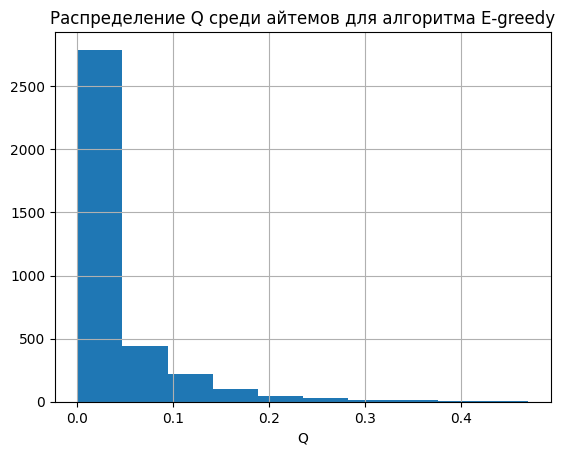

In [ ]:
plt.hist(Q_greedy)
plt.title('Распределение Q среди айтемов для алгоритма E-greedy')
plt.xlabel('Q')
plt.grid()
plt.show()

In [ ]:
def make_predict(weights, test, topk, train, filter_seen=True):
    num_user = train['user_id'].max() + 1
    weights_matrix = np.tile(weights, num_user).reshape(-1, weights.shape[0])
    if filter_seen:
        rating_matrix = pd.pivot_table(train, values='rating', index='user_id', columns='item_id').fillna(0).to_numpy()
        weights_matrix = np.multiply(weights_matrix, np.invert(rating_matrix.astype(bool)))

    ind_part = np.argpartition(weights_matrix, -topk)[:, -topk:].copy()
    scores_not_sorted = np.take_along_axis(weights_matrix, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    scores_sorted = np.sort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)

    pred = pd.DataFrame({
        'user_id': range(weights_matrix.shape[0]),
        'item_id': list(indices),
        'rating': list(scores_sorted)
    }).explode(['item_id', 'rating'])

    return pred

In [ ]:
%%time
predict = make_predict(Q_greedy, test, topk=10, train=train)

CPU times: user 1.09 s, sys: 424 ms, total: 1.51 s
Wall time: 1.37 s


In [ ]:
metrics = [HitRate(topk=10), NDCG(topk=10), Coverage(topk=10)]

In [ ]:
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

{'HitRate@10': 0.6051693404634582,
 'NDCG@10': 0.20209722798278207,
 'Coverage@10': 0.0363189513926816}

### UCB

In [ ]:
def UCB(batch, item_rewards, item_counts, item_bound, t, alpha):
    item_bound = alpha * np.sqrt(2 * np.log(t) / item_counts)
    pred_item = np.argmax(item_rewards / item_counts + item_bound)
    num_user = batch['user_id'].nunique()
    users = batch['user_id'].unique()

    value_count = batch['item_id'].value_counts()
    if pred_item in batch['item_id'].unique():
        count_item = int(value_count[pred_item])
    else:
        count_item = 0

    item_rewards[pred_item] += count_item
    item_counts[pred_item] += num_user

    return item_rewards, item_counts, item_bound

In [ ]:
def fit_ucb(data, num_batches, alpha=2):
    percentiles = data['timestamp'].quantile([i / num_batches for i in range(num_batches+1)]).tolist()
    perv_percentile = percentiles[1]
    batch = data[data['timestamp'] < perv_percentile]

    item_rewards = np.zeros(data['item_id'].max() + 1)
    item_counts = np.ones(data['item_id'].max() + 1)
    item_bound = np.zeros(data['item_id'].max() + 1)

    for t, percentile in enumerate(tqdm(percentiles[2:], desc = 'Progress bar')):
      batch = data[data['timestamp'] < percentile]
      item_rewards, item_counts, item_bound = UCB(batch, item_rewards, item_counts, item_bound, t, alpha)

    Q = item_rewards / item_counts + item_bound

    return Q

In [ ]:
Q_ucb = fit_ucb(data=train, num_batches=8000, alpha=0.5)

Progress bar:   0%|          | 0/7999 [00:00<?, ?it/s]

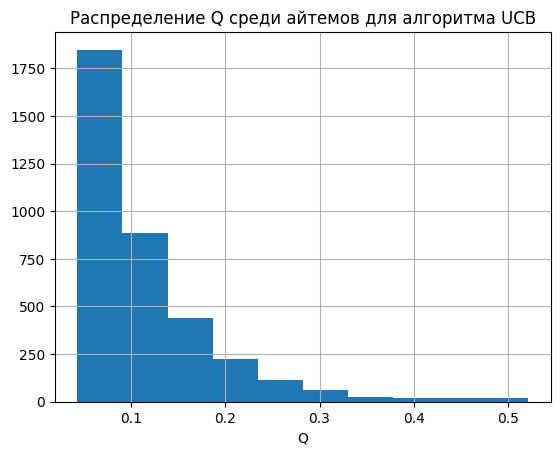

In [ ]:
plt.hist(Q_ucb)
plt.title('Распределение Q среди айтемов для алгоритма UCB')
plt.xlabel('Q')
plt.grid()
plt.show()

In [ ]:
predict = make_predict(Q_ucb, test, topk=10, train=train)
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

{'HitRate@10': 0.48484848484848486,
 'NDCG@10': 0.10019676101007258,
 'Coverage@10': 0.013653741125068269}

In [ ]:
Q_ucb = fit_ucb(data=train, num_batches=8000, alpha=1)

Progress bar:   0%|          | 0/7999 [00:00<?, ?it/s]

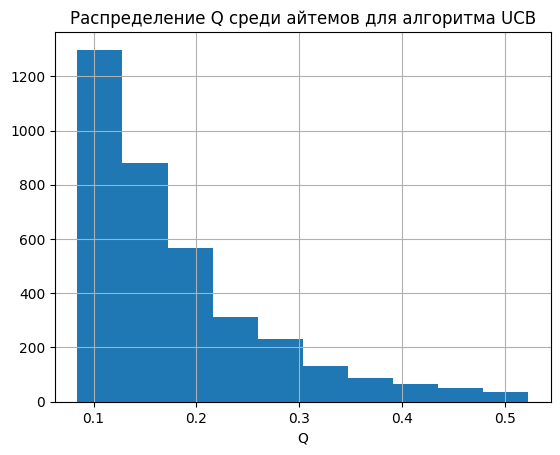

In [ ]:
# alpha = 1
plt.hist(Q_ucb)
plt.title('Распределение Q среди айтемов для алгоритма UCB')
plt.xlabel('Q')
plt.grid()
plt.show()

In [ ]:
predict = make_predict(Q_ucb, test, topk=10, train=train)
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

{'HitRate@10': 0.3761140819964349,
 'NDCG@10': 0.06377992515500235,
 'Coverage@10': 0.009284543965046422}

In [ ]:
Q_ucb = fit_ucb(data=train, num_batches=8000, alpha=2)

Progress bar:   0%|          | 0/7999 [00:00<?, ?it/s]

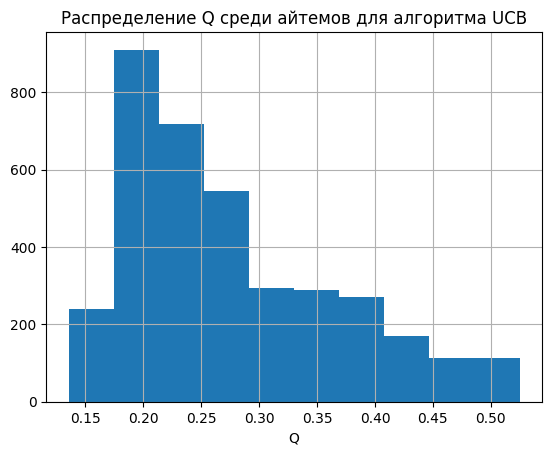

In [ ]:
# alpha = 2
plt.hist(Q_ucb)
plt.title('Распределение Q среди айтемов для алгоритма UCB')
plt.xlabel('Q')
plt.grid()
plt.show()

In [ ]:
predict = make_predict(Q_ucb, test, topk=10, train=train)
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

{'HitRate@10': 0.30124777183600715,
 'NDCG@10': 0.04260754309149072,
 'Coverage@10': 0.010922992900054615}